# Clean up this script
- clean up plots
- remove obsolete code blocks

In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# -------------------------------------------------------------------------------------------------------
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('talk')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import kgraph
import turbpy
import turbpy.multiConst as mc

# -------------------------------------------------------------------------------------------------------
# Directory Lists
# -------------------------------------------------------------------------------------------------------
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'  # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirData = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'  # Processed data directory

In [2]:
# -------------------------------------------------------------------------------------------------------
# Open netcdfs
# -------------------------------------------------------------------------------------------------------
os.chdir(dirData)
Atower = xr.open_dataset('SCP.Atower.netcdf')
Ctower = xr.open_dataset('SCP.Ctower.netcdf')
Mtower = xr.open_dataset('SCP.Mtower.netcdf')
soilObs = xr.open_dataset('SCP.soil_obs.netcdf')
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

//anaconda/lib/python3.5/site-packages/xarray/backends/netCDF4_.py:267: UserWarning: 
A segmentation fault may occur when the
file path has exactly 88 characters as it does.
in this case. The issue is known to occur with
version 1.2.4 of netCDF4 and can be addressed by
upgrading netCDF4 to at least version 1.3.1.
More details can be found here:
https://github.com/pydata/xarray/issues/1745  

  '\nA segmentation fault may occur when the\n'


In [3]:
aggFlag = False
# -------------------------------------------------------------------------------------------------------
# Aggregate to half and hour
# -------------------------------------------------------------------------------------------------------
if aggFlag:
    # 30 minute averages of fluxes
    fluxObs_30m = fluxObs.resample(freq='30Min',how='mean',dim='time')
    radObs_30m = radObs.resample(freq='30Min',how='mean',dim='time')
    soilObs_30m = soilObs.resample(freq='30Min',how='mean',dim='time')

    # Mean ground heat flux @ both sites
    soilObs_30m['Gsfc'] = xr.concat([soilObs_30m.Gsfc_c,\
                                        soilObs_30m.Gsfc_g],dim='site').mean(dim='site')
    soilObs_30m['Gsoil_5cm'] = xr.concat([soilObs_30m.Gsoil_5cm_c,\
                                        soilObs_30m.Gsoil_5cm_g],dim='site').mean(dim='site')
    # Save 30min averages
    os.chdir(dirData)
    fluxObs_30m.to_netcdf('SCP.flux_obs_30m.netcdf')
    radObs_30m.to_netcdf('SCP.rad_obs_30m.netcdf')
    soilObs_30m.to_netcdf('SCP.soil_obs_30m.netcdf')
    
# -------------------------------------------------------------------------------------------------------
# Load 30min averages
# -------------------------------------------------------------------------------------------------------
elif not aggFlag:
    os.chdir(dirData)
    fluxObs_30m = xr.open_dataset('SCP.flux_obs_30m.netcdf')
    radObs_30m = xr.open_dataset('SCP.rad_obs_30m.netcdf')
    soilObs_30m = xr.open_dataset('SCP.soil_obs_30m.netcdf')

In [14]:
########
# Surface temperature from upwelling longwave
sigma = 5.67*10**-8.                   # Stefan-Boltzmann constant
epsilon = 0.98
Tsfc = (radObs.Rlw_out / (0.98 * sigma))**(1./4.)

# Insert into Mtower xarray.Dataset
Mtower['Tsfc'] = (('time'), Tsfc-273.15)

########
# Bulk Richardson Number
Mtower['UBar_15m'] = (('time'), (Mtower.U_15m_M**2 + Mtower.V_15m_M**2)**(1. / 2.))
Mtower.UBar_15m[Mtower.UBar_15m > 10] = np.nan
Mtower['UBar_2m'] = (('time'), (Mtower.u_2m_M**2 + Mtower.v_2m_M**2)**(1. / 2.))
Mtower.UBar_15m[Mtower.UBar_2m > 10] = np.nan

RiBulk_15m,_,_ = turbpy.bulkRichardson(Mtower.T_15m_M + 273.15,
                                       Mtower.Tsfc + 273.15,
                                       Mtower.UBar_15m, 15.)
Mtower['RiBulk_15m'] = RiBulk_15m

RiBulk_2m,_,_ = turbpy.bulkRichardson(Mtower.T_1m_M + 273.15,
                                      Mtower.Tsfc + 273.15,
                                      Mtower.UBar_2m, 2.)
Mtower['RiBulk_2m'] = RiBulk_2m

SCPind = np.nonzero((Mtower.RiBulk_15m > 0.).values)

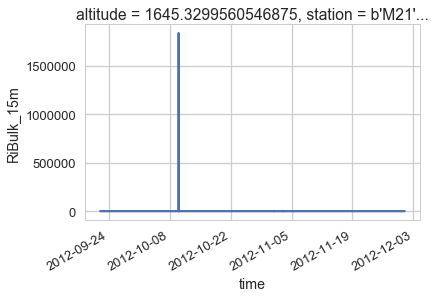

# Offline Turbulence
- Run in the script TF.SUMMATurbConversion_SCP.py script on j-lundquist-3
- Results saved to OfflineTurb.SCP.sensible_1m.ALL.nc. The "ALL" refers to doing offline simulations on all stable conditions, instead of just a 5% sample, as in previous iterations.
- The criteria for stable conditions comes from the 15m observations 

In [5]:
os.chdir(dirProj)
sensible_1m = xr.open_dataset('OfflineTurb.SCP.sensible_1m.ALL.nc')
sensible_15m = xr.open_dataset('OfflineTurb.SCP.sensible_15m.ALL.nc')
latent_1m = xr.open_dataset('OfflineTurb.SCP.latent_1m.ALL.nc')
latent_15m = xr.open_dataset('OfflineTurb.SCP.latent_15m.ALL.nc')

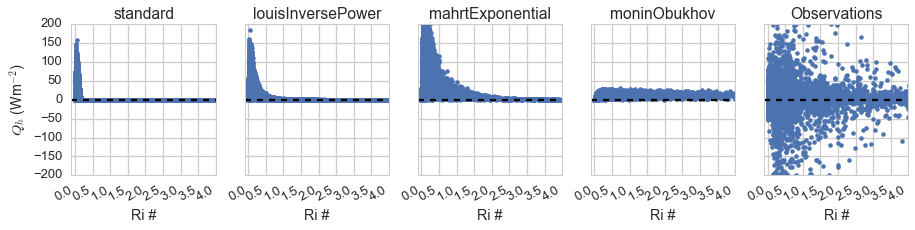

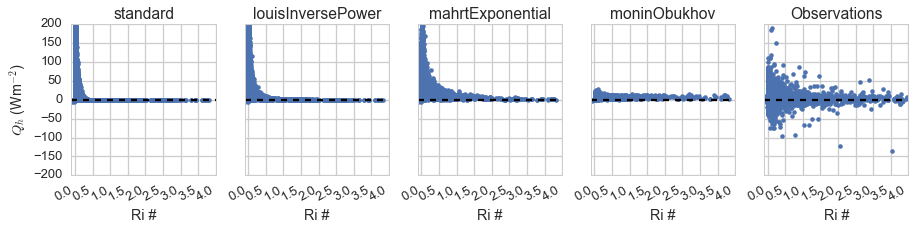

In [66]:
########
# Sensible 15m
os.chdir(dirPrint)
fig,axes = plt.subplots(1,5,sharey=True,figsize=(15,3))
Qmax = 200
Qmin = -200
RiMax = 4.
RiMin = -0.1
ixStability = ('standard',
               'louisInversePower',
               'mahrtExponential',
               'moninObukhov')
ind = np.nonzero((Mtower.RiBulk_15m > 0.).values)

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(Mtower.RiBulk_15m[ind], sensible_15m[stab],'.',label=stab)
    ax.plot([RiMin,RiMax],[0,0],'k--')
    ax.set_xlim(RiMin,RiMax)
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(Mtower.RiBulk_15m[ind],
        -fluxObs.w_tc__10m_M[ind],
        '.', label='Observations')
ax.plot([RiMin, RiMax], [0, 0], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_title('Observations')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible_Ri.pdf')

########
# Sensible 2m
os.chdir(dirPrint)
fig,axes = plt.subplots(1,5,sharey=True,figsize=(15,3))

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(Mtower.RiBulk_2m[ind], sensible_1m[stab],'.',label=stab)
    ax.plot([RiMin,RiMax],[0,0],'k--')
    ax.set_xlim(RiMin,RiMax)
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(Mtower.RiBulk_2m[ind], \
        -fluxObs.w_tc__2m_M[ind],\
        '.',label='Observations')
ax.plot([RiMin,RiMax],[0,0],'k--')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(RiMin,RiMax)
ax.set_xlabel('Ri #')
ax.set_title('Observations')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Latent_Ri.pdf')


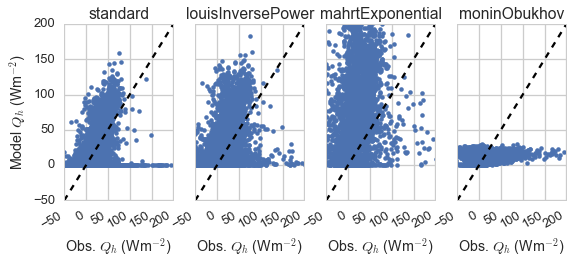

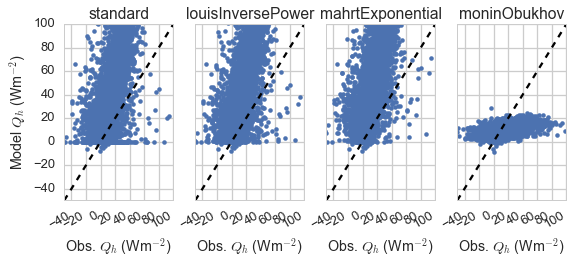

In [64]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(9,3.5))
Qmax = 200
Qmin = -50

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(-fluxObs.w_tc__10m_M[ind], sensible_15m[stab],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible.pdf')

########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(9,3.5))
Qmax = 100
Qmin = -50

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(-fluxObs.w_tc__2m_M[ind], sensible_1m[stab], '.', label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible.pdf')

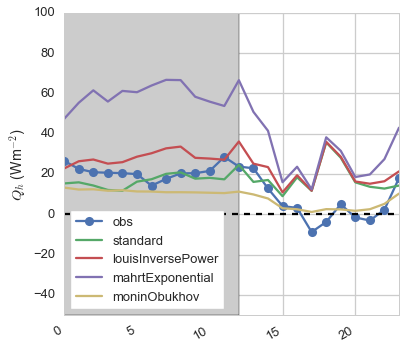

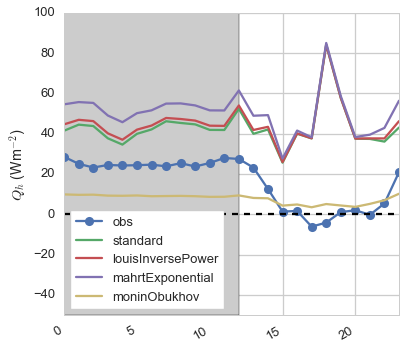

In [44]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,ax = plt.subplots(1, 1, sharey=True, figsize=(6, 6))
Qmax = 100
Qmin = -50

ax.plot(np.arange(0, 24),
        -fluxObs.w_tc__10m_M[ind].groupby('time.hour').mean(dim='time'), '-o',
        label='obs')
ax.plot([0, 23], [0, 0], 'k--')
ax.fill_between(np.arange(0, 13), Qmin, Qmax, facecolor='0.8')
for n,stab in enumerate(ixStability):
    ax.plot(np.arange(0, 24),
            sensible_15m[stab].groupby('time.hour').mean(dim='time'),
            label=stab)
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(0, 23)
    ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')
ax.legend(loc='best', frameon=True)
fig.autofmt_xdate()

########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,ax = plt.subplots(1, 1, sharey=True, figsize=(6, 6))
Qmax = 100
Qmin = -50

ax.plot(np.arange(0, 24),
        -fluxObs.w_tc__2m_M[ind].groupby('time.hour').mean(dim='time'), '-o',
        label='obs')
ax.plot([0, 23], [0, 0], 'k--')
ax.fill_between(np.arange(0, 13), Qmin, Qmax, facecolor='0.8')
for n,stab in enumerate(ixStability):
    ax.plot(np.arange(0, 24),
            sensible_1m[stab].groupby('time.hour').mean(dim='time'),
            label=stab)
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(0, 23)
    ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')
ax.legend(loc='best', frameon=True)
fig.autofmt_xdate()

In [67]:
ind = np.nonzero((Mtower.RiBulk_15m > 0.).values)
for n, stab in enumerate(ixStability):
    print(stab + ': ' + str(np.nanmean(sensible_1m[stab].values - fluxObs.w_tc__2m_M[ind].values)))

print('\n')
for n, stab in enumerate(ixStability):
    print(stab + ': ' + str(np.nanmean(sensible_15m[stab].values - fluxObs.w_tc__10m_M[ind].values)))

standard: 56.0997578095
louisInversePower: 58.2365419931
mahrtExponential: 66.1258750395
moninObukhov: 23.2512354645


standard: 27.5942087723
louisInversePower: 37.8768511823
mahrtExponential: 65.7983620328
moninObukhov: 22.1125299783


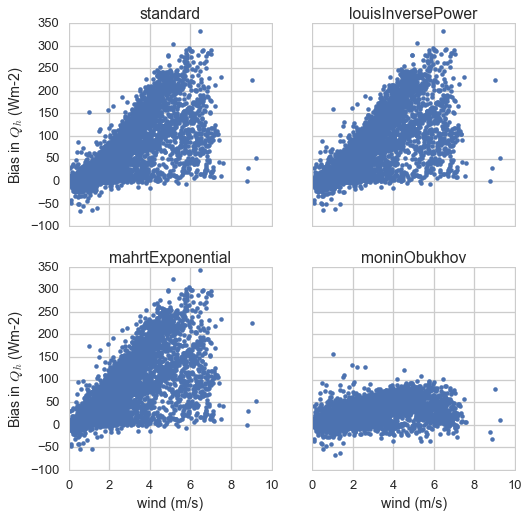

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex='col', sharey='row')
axes = axes.flatten()
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.plot(Mtower.UBar_2m[ind],
            sensible_1m[stab].values - fluxObs.w_tc__2m_M[ind].values, '.')
    ax.set_title(stab)
    if ix == 0 or ix == 2:
        ax.set_ylabel('Bias in $Q_h$ (Wm-2)')
    if ix > 1:
        ax.set_xlabel('wind (m/s)')

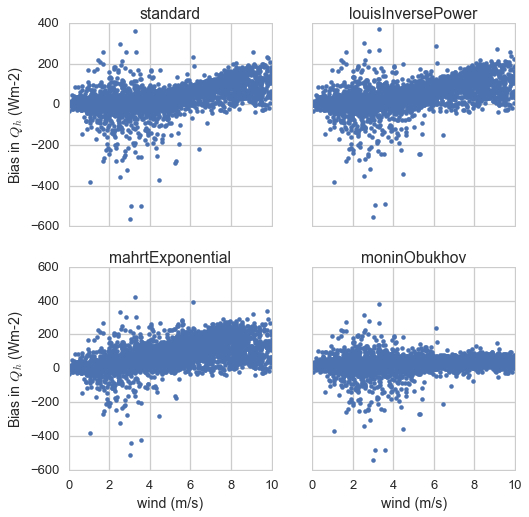

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex='col', sharey='row')
axes = axes.flatten()
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.plot(Mtower.UBar_15m[ind],
            sensible_15m[stab].values - fluxObs.w_tc__10m_M[ind].values, '.')
    ax.set_title(stab)
    if ix == 0 or ix == 2:
        ax.set_ylabel('Bias in $Q_h$ (Wm-2)')
    if ix > 1:
        ax.set_xlabel('wind (m/s)')

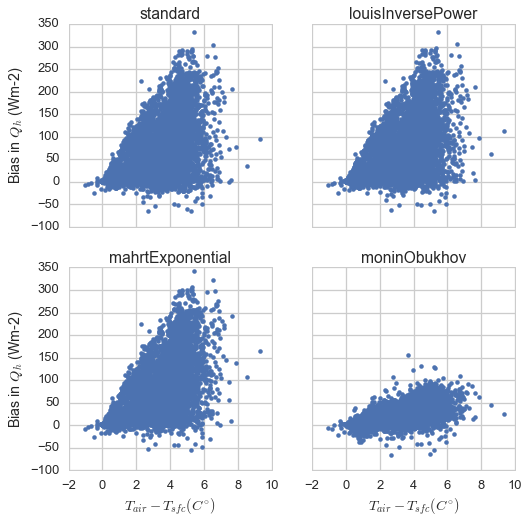

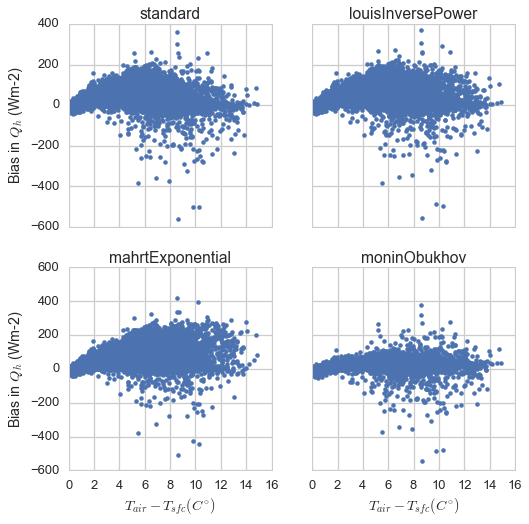

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex='col', sharey='row')
axes = axes.flatten()
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.plot(Mtower.T_1m_M[ind] - Mtower.Tsfc[ind], 
            sensible_1m[stab].values - fluxObs.w_tc__2m_M[ind].values, '.')
    ax.set_title(stab)
    if ix == 0 or ix == 2:
        ax.set_ylabel('Bias in $Q_h$ (Wm-2)')
    if ix > 1:
        ax.set_xlabel('$T_{air} - T_{sfc} (C^{\circ})$')
    
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex='col', sharey='row')
axes = axes.flatten()
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.plot(Mtower.T_15m_M[ind] - Mtower.Tsfc[ind], 
            sensible_15m[stab].values - fluxObs.w_tc__10m_M[ind].values, '.')
    ax.set_title(stab)
    if ix == 0 or ix == 2:
        ax.set_ylabel('Bias in $Q_h$ (Wm-2)')
    if ix > 1:
        ax.set_xlabel('$T_{air} - T_{sfc} (C^{\circ})$')

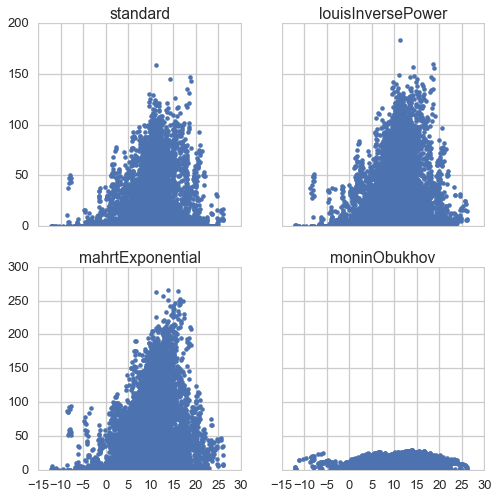

In [90]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex='col', sharey='row')
axes = axes.flatten()
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.plot(Mtower.T_15m_M[ind], 
            sensible_15m[stab].values, '.')
    ax.set_title(stab)

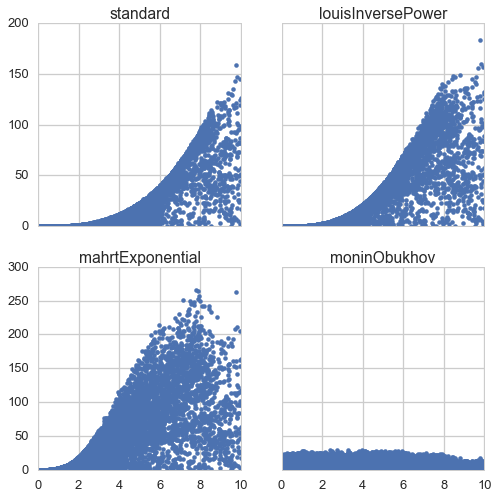

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex='col', sharey='row')
axes = axes.flatten()
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.plot(Mtower.UBar_15m[ind], 
            sensible_15m[stab].values, '.')
    ax.set_title(stab)

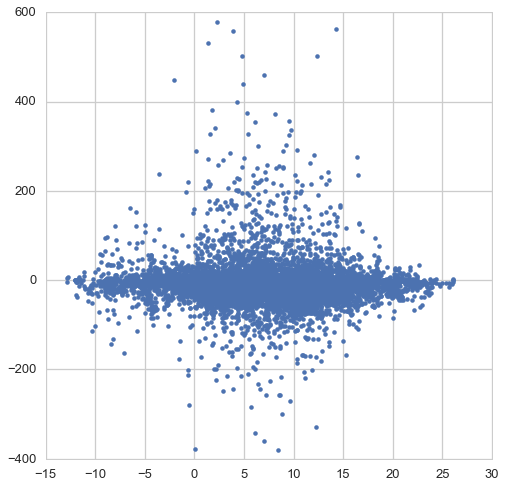

In [94]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8), sharex='col', sharey='row')

ax = axes
ax.plot(Mtower.T_15m_M[ind], 
        fluxObs.w_tc__10m_M[ind].values, '.')

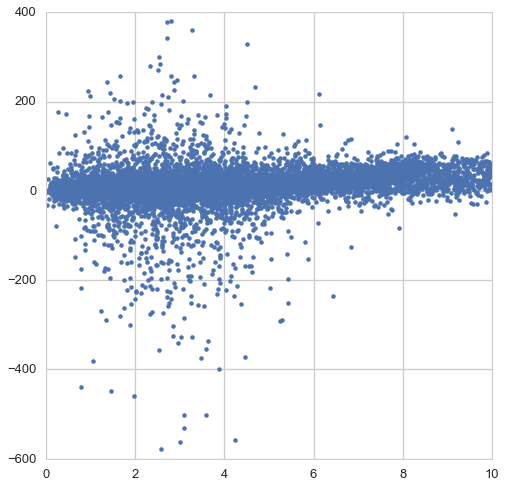

In [96]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8), sharex='col', sharey='row')
axes = axes.flatten()
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    ax.plot(Mtower.UBar_15m[ind], 
            sensible_15m[stab].values, '.')
    ax.set_title(stab)

ax = axes
ax.plot(Mtower.UBar_15m[ind], 
        -fluxObs.w_tc__10m_M[ind].values, '.')